In [13]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sn
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes


In [73]:
data_raw = pd.read_csv("C:\\Users\\Leni\\Documents\\UNI\\Data Challenges\\data\\analysis_dataset.csv", sep=";")
data_clusters = data_raw[['coin']].copy()
coin_ids = data_raw['coin']
del data_raw["coin"]
del data_raw["findspot"] #empty column
del data_raw["Unnamed: 0"]
del data_raw["mindiam"]
features_raw = data_raw.columns #column names
index_raw = data_raw.index

print("data raw")
#print(data_raw)


data raw


In [29]:
def mat_cat(data):
    """Dummy Variable material zurückführen"""
    material_col = data[['material_ ae ', 'material_ ar ', 'material_ av ', 'material_ cu ', 'material_ el ','material_ pb ']].idxmax(axis=1)
    #### TODO: missing values !
    material_col = material_col.to_frame(name='material')
    material_col['material'] = material_col['material'].str.replace("material_ ", "")
    data_material_col = data.join(material_col)
    for mat in ['material_ ae ', 'material_ ar ', 'material_ av ', 'material_ cu ', 'material_ el ','material_ pb ']:
        del data_material_col[mat]

    # cat encoding for material
    data_material_col['material'] = data_material_col['material'].astype('category')
    data_material_col[f'mat_cat'] = data_material_col['material'].cat.codes
    #data_material_col.drop(['material'], axis=1)
    del data_material_col['material']
    print('data_material_col')
    
    features = data_material_col.columns #column names
    index = data_material_col.index
    
    return data_material_col, features, index


def imput_it(data):
    """Imputieren von fehlenden Werten mit iterativem Imputer (gleich dbscan)"""
    imp = IterativeImputer(max_iter=10, random_state=0)
    imp_data = data.copy()
    head = data.columns
    for col in data.columns:
        imp.fit(np.array(data[col]).reshape(-1,1))
        imp_data[col] = imp.transform(np.array(data[col]).reshape(-1,1))
    imp_data = pd.DataFrame(imp_data, columns=head)

    print("data imputed")
    return imp_data


def scale_st(data, features, index):
    """Daten skalieren"""
    # scale numeric data, MW 0 Std 1
    scaler = StandardScaler()
    scal_data = pd.DataFrame(scaler.fit_transform(data), columns = features, index = index) #ndarray, nan 

    # TODO: handle categorical data?

    print("data scaled")
    data
    
    return scal_data


In [53]:
scal_imp_data = scale_st(imput_it(data_raw), features_raw, index_raw) #imputieren, skalieren
n = 8 #number of clusters

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,}

kmeans = KMeans(n_clusters=n, **kmeans_kwargs)
kmeans.fit(scal_imp_data)
data_clusters['labels_kmeans'] = kmeans.labels_

print("min SSE:", kmeans.inertia_ )
print("#iterations: ", kmeans.n_iter_)
#print("cluster centers: ", kmeans.cluster_centers_)
print(kmeans.labels_)

data imputed
data scaled


min SSE: 261380.59551924604
#iterations:  41
[3 3 2 ... 1 7 7]


In [60]:
data, features, index = mat_cat(data_raw) #Dummy-Variable material auflösen
scal_imp_data = scale_st(imput_it(data), features, index) #imputieren, skalieren 
n = 8 #number of clusters

kproto = KPrototypes(n_clusters=n, init='Cao')
clusters = kproto.fit_predict(scal_imp_data, categorical=[5,6,7,8]) #column indices that are categorical 

print("min SSE:") #?
print("#iterations: ", kproto.n_iter_)
#print("cluster centers: ", kmeans.cluster_centers_)
print(kproto.labels_)

# TODO: The k-prototypes also accepts np.NaN values as missing values for the categorical variables, but doesnot accept missing values for the numerical values.

data_material_col
data imputed
data scaled


min SSE:
#iterations:  22
[0 4 5 ... 2 0 5]


          coin  labels_kmodes  labels_kmeans
0      31084.0              0              3
1      13239.0              4              3
2      24329.0              5              2
3      36245.0              2              2
4       8127.0              0              3
...        ...            ...            ...
41083  21804.0              2              1
41084  40295.0              5              2
41085  38805.0              2              1
41086  31071.0              0              7
41087  12182.0              5              7

[41088 rows x 3 columns]


0    8596
2    8070
5    8061
4    5964
6    4023
7    3562
3    1866
1     946
Name: 0, dtype: int64
                 maxdiam           weight           enddate         startdate  \
                    mean count       mean count        mean count        mean   
labels_kmeans                                                                   
0              28.264025  2527  15.252399  3435 -211.129656  2846 -251.687170   
1              14.908691   955   9.343892   740 -443.631966   951 -513.123028   
2              15.344840  6515   3.708459  7396 -234.959698  6898 -299.217164   
3              22.738455  6807   7.113832  6758  185.986582  7676  165.640047   
4              32.304512  3916  20.267052  4121  205.416433  3919  196.234243   
5              17.811957   276   8.275081   370 -282.384615   234 -319.444444   
6              14.347964  3732   3.016558  4806 -366.714716  4315 -400.210660   
7              21.947238  6194   6.589864  7740  169.850988  6476  145.825637   

      

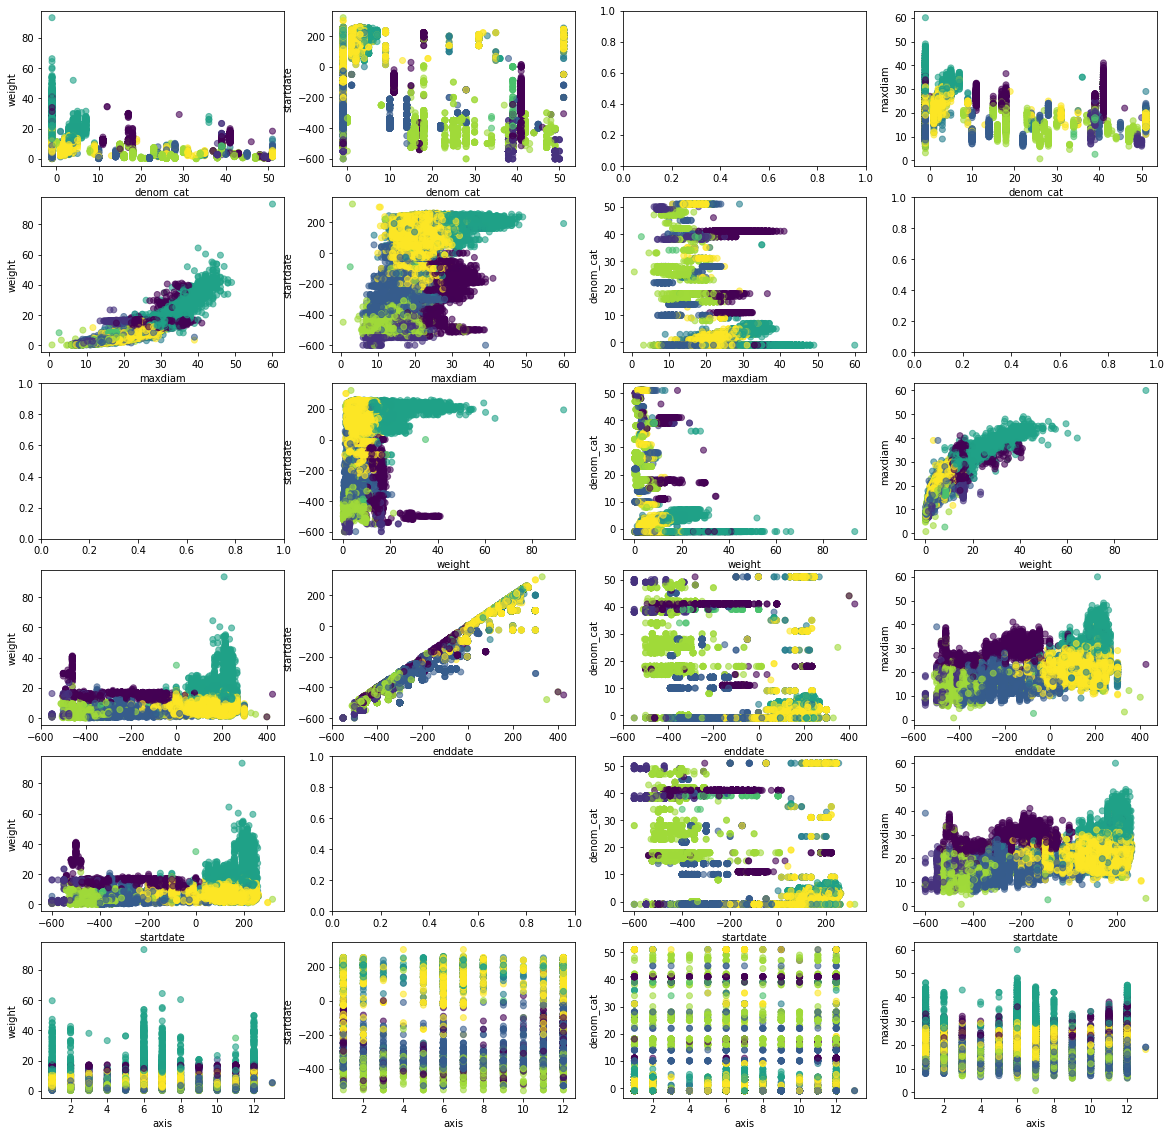

In [95]:
#'maxdiam', 'weight', 'enddate', 'startdate', 'axis',
#'material_ ae ','material_ ar ', 'material_ av ', 'material_ cu ', 'material_ el ', #'material_ pb ', 
#'denom_cat', 'mint_cat', 'collection_cat']

def plot_feat_matrix(data, algo):
    features_anal1 = ['denom_cat', 'maxdiam', 'weight','enddate', 'startdate', 'axis', ]#,'denom_cat', 'mint_cat', 'collection_cat' ]
    features_anal2 = ['weight', 'startdate', 'denom_cat', 'maxdiam']
    fig, axs = plt.subplots(len(features_anal1), len(features_anal2), sharex=False, sharey=False, figsize=(20, 20))
    y, x = 0, 0

    for feature1 in features_anal1:
        for feature2 in features_anal2:
            if not feature1 == feature2:
                axs[x, y].scatter(data[feature1], data[feature2], c=data[f"labels_{algo}"], alpha=0.6)
                axs[x, y].set_xlabel(feature1)
                axs[x, y].set_ylabel(feature2)
            y += 1
        y = 0
        x += 1

    plt.savefig(f'{algo}_plot.png')
    print('plot saved')

data = pd.concat([data_raw, data_clusters], axis=1)
print(pd.DataFrame(kproto.labels_)[0].value_counts())
#algo = 'kmodes'
algo = 'kmeans'

data_agg = data.groupby(f"labels_{algo}").agg(["mean", "count"])
print(data_agg)
plot_feat_matrix(data, algo)

In [57]:
data_clusters.to_csv("clusters_.csv", sep=";") # coin-IDs + cluster labels

data imputed
data scaled


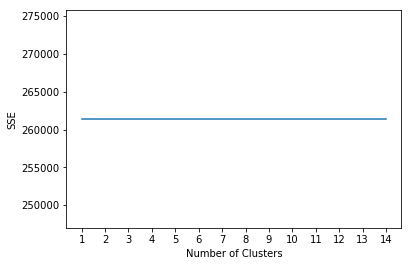

elbow point KneeLocator:  None


C:\Users\Leni\Anaconda3\lib\site-packages\kneed\knee_locator.py:218: RuntimeWarning: invalid value encountered in true_divide
  return (a - min(a)) / (max(a) - min(a))
C:\Users\Leni\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater_equal
  results &= comparator(main, plus)
C:\Users\Leni\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater_equal
  results &= comparator(main, minus)
C:\Users\Leni\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:77: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, plus)
C:\Users\Leni\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:78: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, minus)
C:\Users\Leni\Anaconda3\lib\site-packages\kneed\knee_locator.py:242: RuntimeWarning: No local maxima found in the difference curve
The line is probably 

In [98]:
max_clusters = 15
scal_imp_data = scale_st(imput_it(data_raw), features_raw, index_raw) #imputieren, skalieren

sse = []
for k in range(1, max_clusters):
    kmeans.fit(scal_imp_data)
    sse.append(kmeans.inertia_)

plt.plot(range(1, max_clusters), sse)
plt.xticks(range(1, max_clusters))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


#elbow point
kl = KneeLocator(
    range(1, max_clusters), sse, curve="convex", direction="decreasing")
print("elbow point KneeLocator: ", kl.elbow)